# Predictive Analysis - Parks and Arrests

#### Elise Chessman

After exploring the census data, park data, and NYPD arrest data, it appears as if there is not much of a relationship between parks and the type of arrests that occur. Next, we will focus on if demographic factors of the neigbhorhoods where the arrests occur that are also close to parks might influence if the model predicts arrests. First I'll bring in my dataframe of arrests from the NYPD for all of 2021, with a boolean column of whether or not those arrests occurred within 100m of a park. 

In [2]:
import pandas as pd
import geopandas as gpd
import requests
import json

This is the same arrests dataset, but with a boolean column of if the arrest occurred within 100m of a park.

In [3]:
parkarrests = pd.read_pickle('../NYCParks-SAEC/parkarrests.pandas')

parkarrests = gpd.GeoDataFrame(parkarrests, 
                        geometry = gpd.points_from_xy(
                         parkarrests.longitude, 
                         parkarrests.latitude, crs='EPSG:4326'))
pd.set_option('display.max_columns', None)

parkarrests = parkarrests.rename(columns={'index_right':'old'})
parkarrests.head(2)


,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,geometry,old,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,retired,communityboard,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,dist_to_park,hundred_m
0,238013474,2021-12-18T00:00:00.000,157,RAPE 1,104.0,RAPE,PL 1303501,F,Q,105,97,18-24,M,BLACK,1057636,203954,40.72618713000002,-73.73523390399998,"{'type': 'Point', 'coordinates': [-73.73523390...",63,3,16,63,24337,POINT (-73.73523 40.72619),771,Grand Central Parkway,None,11427,12.95352546,"North Of Grand Central Pkwy, From Bell Blvd To...",24,23,Grand Central Parkway-Potamogeton Pond,6,Q084,False,411,Q-11,Large Park Zone,112,Q084-ZN01,Potamogeton Pond,14,Q,1218.925045,False
8,233697123,2021-09-17T00:00:00.000,157,RAPE 1,104.0,RAPE,PL 1303501,F,Q,105,0,25-44,M,BLACK,1057636,203954,40.72618713000002,-73.73523390399998,"{'type': 'Point', 'coordinates': [-73.73523390...",63,3,16,63,24337,POINT (-73.73523 40.72619),771,Grand Central Parkway,None,11427,12.95352546,"North Of Grand Central Pkwy, From Bell Blvd To...",24,23,Grand Central Parkway-Potamogeton Pond,6,Q084,False,411,Q-11,Large Park Zone,112,Q084-ZN01,Potamogeton Pond,14,Q,1218.925045,False


## Bringing in the Census Data

#### Stephanie Andrade

This is all copied over from Steph's notebook working on the census data.

In [4]:
r = requests.get('https://api.census.gov/data/2015/acs/acs5?get=NAME,B01001_001E,B01001H_001E&for=county:*&for=tract:*&in=state:36')
print(r.text)

censusdata = r.json()

# Turn JSON into a pandas dataframe
df = pd.DataFrame(censusdata[1:], columns=censusdata[0])
df.head()

[["NAME","B01001_001E","B01001H_001E","state","county"],
["Schoharie County, New York","31913","29868","36","095"],
["Fulton County, New York","54606","50960","36","035"],
["Rensselaer County, New York","159900","135285","36","083"],
["Franklin County, New York","51280","41999","36","033"],
["Queens County, New York","2301139","601381","36","081"],
["Washington County, New York","62700","58182","36","115"],
["New York County, New York","1629507","767701","36","061"],
["Cayuga County, New York","79173","71808","36","011"],
["Rockland County, New York","320688","204596","36","087"],
["Niagara County, New York","214150","185219","36","063"],
["Essex County, New York","38912","35886","36","031"],
["Nassau County, New York","1354612","851645","36","059"],
["Jefferson County, New York","118947","98419","36","045"],
["Suffolk County, New York","1501373","1045354","36","103"],
["Wyoming County, New York","41446","37232","36","121"],
["Oswego County, New York","121183","114552","36","075"],
["W

,NAME,B01001_001E,B01001H_001E,state,county
0,"Schoharie County, New York",31913,29868,36,095
1,"Fulton County, New York",54606,50960,36,035
2,"Rensselaer County, New York",159900,135285,36,083
3,"Franklin County, New York",51280,41999,36,033
4,"Queens County, New York",2301139,601381,36,081


In [5]:
# Renaming the column to be more specfic
df.rename(columns = {'B01001_001E':'Population','B01001H_001E':'NonHispanicWhite'}, inplace=True)
df

,NAME,Population,NonHispanicWhite,state,county
0,"Schoharie County, New York",31913,29868,36,095
1,"Fulton County, New York",54606,50960,36,035
2,"Rensselaer County, New York",159900,135285,36,083
3,"Franklin County, New York",51280,41999,36,033
4,"Queens County, New York",2301139,601381,36,081
...,...,...,...,...,...
57,"Cattaraugus County, New York",78962,71985,36,009
58,"Madison County, New York",72427,67735,36,053
59,"Schenectady County, New York",154796,116261,36,093
60,"Genesee County, New York",59458,54029,36,037


In [6]:
# Create a new column that will give us the perentage of nonhispanic white individuals in New York State.
df['prc_NonHispanicWhite'] = df.NonHispanicWhite.astype(float) / df.Population.astype(float) * 100 
df.head(20)

,NAME,Population,NonHispanicWhite,state,county,prc_NonHispanicWhite
0,"Schoharie County, New York",31913,29868,36,095,93.591953
1,"Fulton County, New York",54606,50960,36,035,93.323078
2,"Rensselaer County, New York",159900,135285,36,083,84.606004
3,"Franklin County, New York",51280,41999,36,033,81.901326
4,"Queens County, New York",2301139,601381,36,081,26.134058
5,"Washington County, New York",62700,58182,36,115,92.794258
6,"New York County, New York",1629507,767701,36,061,47.112470
7,"Cayuga County, New York",79173,71808,36,011,90.697586
8,"Rockland County, New York",320688,204596,36,087,63.799082
9,"Niagara County, New York",214150,185219,36,063,86.490311


In [7]:
def get_nhWhite(countyFIPS):
    r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E,B01001H_001E&for=tract:*&in=state:36%20county:{}'.format(countyFIPS))
    censusdata = r.json()
    df = pd.DataFrame(censusdata[1:], columns=censusdata[0])
    df['prc_NonHispanicWhite'] = df.B01001H_001E.astype(float) / df.B01001_001E.astype(float) * 100

    return df

In [8]:
queens_county = get_nhWhite('081')
queens_county

,NAME,B01001_001E,B01001H_001E,state,county,tract,prc_NonHispanicWhite
0,"Census Tract 361, Queens County, New York",2238,73,36,081,036100,3.261841
1,"Census Tract 363, Queens County, New York",1771,66,36,081,036300,3.726708
2,"Census Tract 371, Queens County, New York",1335,19,36,081,037100,1.423221
3,"Census Tract 377, Queens County, New York",3620,17,36,081,037700,0.469613
4,"Census Tract 379, Queens County, New York",6851,63,36,081,037900,0.919574
...,...,...,...,...,...,...,...
664,"Census Tract 660, Queens County, New York",3318,122,36,081,066000,3.676914
665,"Census Tract 683, Queens County, New York",3970,458,36,081,068300,11.536524
666,"Census Tract 716, Queens County, New York",0,0,36,081,071600,NaN
667,"Census Tract 240, Queens County, New York",6826,149,36,081,024000,2.182830


In [9]:
ny_county = get_nhWhite('061')
ny_county

,NAME,B01001_001E,B01001H_001E,state,county,tract,prc_NonHispanicWhite
0,"Census Tract 255, New York County, New York",5999,1602,36,061,025500,26.704451
1,"Census Tract 222, New York County, New York",3369,1084,36,061,022200,32.175720
2,"Census Tract 10.01, New York County, New York",1546,1075,36,061,001001,69.534282
3,"Census Tract 7, New York County, New York",8501,6212,36,061,000700,73.073756
4,"Census Tract 103, New York County, New York",2065,1252,36,061,010300,60.629540
...,...,...,...,...,...,...,...
283,"Census Tract 218, New York County, New York",6236,1280,36,061,021800,20.525978
284,"Census Tract 283, New York County, New York",7949,1537,36,061,028300,19.335766
285,"Census Tract 291, New York County, New York",12165,769,36,061,029100,6.321414
286,"Census Tract 295, New York County, New York",8182,2848,36,061,029500,34.808115


In [10]:
race_Df = gpd.read_file('/users/EliseChessman 1/Documents/Github/NYCParks-SAEC/data/acs2020_5yr_B03002_14000US36047081800.geojson')
race_Df

,geoid,name,B03002001,"B03002001, Error",B03002002,"B03002002, Error",B03002003,"B03002003, Error",B03002004,"B03002004, Error",B03002005,"B03002005, Error",B03002006,"B03002006, Error",B03002007,"B03002007, Error",B03002008,"B03002008, Error",B03002009,"B03002009, Error",B03002010,"B03002010, Error",B03002011,"B03002011, Error",B03002012,"B03002012, Error",B03002013,"B03002013, Error",B03002014,"B03002014, Error",B03002015,"B03002015, Error",B03002016,"B03002016, Error",B03002017,"B03002017, Error",B03002018,"B03002018, Error",B03002019,"B03002019, Error",B03002020,"B03002020, Error",B03002021,"B03002021, Error",geometry
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,684.0,4285.0,584.0,817.0,280.0,3234.0,437.0,27.0,27.0,171.0,69.0,0.0,17.0,0.0,17.0,36.0,25.0,0.0,17.0,36.0,25.0,2315.0,262.0,1743.0,232.0,207.0,71.0,0.0,17.0,0.0,17.0,0.0,17.0,252.0,177.0,113.0,67.0,44.0,41.0,69.0,52.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ..."
1,14000US36005000200,"Census Tract 2, Bronx, NY",4167.0,713.0,1224.0,412.0,77.0,91.0,980.0,382.0,0.0,12.0,115.0,105.0,0.0,12.0,52.0,83.0,0.0,12.0,0.0,12.0,0.0,12.0,2943.0,604.0,1195.0,355.0,414.0,270.0,0.0,12.0,0.0,12.0,0.0,12.0,1030.0,509.0,304.0,259.0,203.0,241.0,101.0,94.0,"MULTIPOLYGON (((-73.86648 40.80590, -73.86231 ..."
2,14000US36005000400,"Census Tract 4, Bronx, NY",5684.0,986.0,1536.0,360.0,371.0,207.0,965.0,315.0,0.0,17.0,87.0,90.0,0.0,17.0,2.0,22.0,111.0,94.0,0.0,17.0,111.0,94.0,4148.0,931.0,1814.0,422.0,383.0,249.0,15.0,24.0,86.0,134.0,0.0,17.0,1723.0,981.0,127.0,113.0,47.0,55.0,80.0,87.0,"MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ..."
3,14000US36005001600,"Census Tract 16, Bronx, NY",5917.0,719.0,2582.0,584.0,229.0,120.0,1986.0,492.0,192.0,224.0,63.0,102.0,0.0,17.0,55.0,58.0,57.0,55.0,21.0,35.0,36.0,43.0,3335.0,462.0,1105.0,304.0,367.0,162.0,0.0,17.0,13.0,20.0,0.0,17.0,1481.0,458.0,369.0,235.0,330.0,231.0,39.0,45.0,"MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ..."
4,14000US36005001901,"Census Tract 19.01, Bronx, NY",1910.0,301.0,881.0,231.0,259.0,103.0,610.0,211.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,12.0,13.0,12.0,13.0,0.0,12.0,1029.0,279.0,365.0,208.0,168.0,113.0,0.0,12.0,0.0,12.0,0.0,12.0,434.0,233.0,62.0,56.0,50.0,57.0,12.0,16.0,"MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,14000US36085030302,"Census Tract 303.02, Richmond, NY",6569.0,838.0,3713.0,547.0,1732.0,332.0,1161.0,441.0,0.0,17.0,638.0,209.0,0.0,17.0,61.0,78.0,121.0,123.0,0.0,17.0,121.0,123.0,2856.0,868.0,1421.0,571.0,13.0,22.0,0.0,17.0,10.0,14.0,0.0,17.0,1246.0,592.0,166.0,205.0,149.0,202.0,17.0,28.0,"MULTIPOLYGON (((-74.16814 40.62208, -74.16793 ..."
2323,14000US36085031901,"Census Tract 319.01, Richmond, NY",3293.0,681.0,2236.0,539.0,311.0,181.0,1654.0,502.0,0.0,12.0,271.0,200.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,1057.0,476.0,690.0,354.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,194.0,191.0,173.0,255.0,173.0,255.0,0.0,12.0,"MULTIPOLYGON (((-74.16647 40.62852, -74.16645 ..."
2324,14000US36085031902,"Census Tract 319.02, Richmond, NY",4953.0,739.0,3350.0,691.0,498.0,219.0,2613.0,697.0,0.0,12.0,121.0,137.0,0.0,12.0,0.0,12.0,118.0,108.0,0.0,12.0,118.0,108.0,1603.0,482.0,961.0,486.0,282.0,215.0,29.0,48.0,0.0,12.0,0.0,12.0,249.0,222.0,82.0,102.0,65.0,99.0,17.0,26.0,"MULTIPOLYGON (((-74.17129 40.64052, -74.17118 ..."
2325,14000US36085032300,"Census Tract 323, Richmond, NY",1200.0,380.0,812.0,383.0,135.0,70.0,411.0,139.0,0.0,12.0,15.0,23.0,0.0,12.0,17.0,23.0,234.0,338.0,0.0,12.0,234.0,338.0,388.0,106.0,329.0,92.0,4.0,7.0,0.0,12.0,0.0,12.0,0.0,12.0,23.0,25.0,32.0,34.0,0.0,12.0,32.0,34.0,"MULTIPOLYGON (((-74.19742 40.63592, -74.19739 ..."


In [11]:
keep_race_Df = ['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002010',
 'B03002011',
 'B03002012',
 'B03002013',
 'B03002014',
 'B03002015',
 'B03002016',
 'B03002017',
 'B03002018',
 'B03002019',
 'B03002020',
 'B03002021',
 'geometry']

In [12]:
race_Df = race_Df[keep_race_Df ]

In [13]:
race_Df.columns = ['geoid', 'name','Total',
                   'Not Hispanic', 
                   'White',
                   'Black',
                   'American Indian and Alaska Native',
                   'Asian',
                   'Pacific Islander',
                   'Other Race',
                   'Two or more races',
                   'Two or more races including other race',
                   'Three or more races',
                   'Hispanic',
                   'Hispanic White',
                   'Hispanic Black',
                   'Hispanic American Indian and Alaska Native',
                   'Hispanic Asian',
                   'Hispanic Pacific Islander',
                   'Hispanic Other Race',
                   'Hispanic Two or more races',
                   'Hispanic Two or more races including other race',
                   'Hispanic Three or more races','geometry']

In [14]:
list(race_Df)

['geoid',
 'name',
 'Total',
 'Not Hispanic',
 'White',
 'Black',
 'American Indian and Alaska Native',
 'Asian',
 'Pacific Islander',
 'Other Race',
 'Two or more races',
 'Two or more races including other race',
 'Three or more races',
 'Hispanic',
 'Hispanic White',
 'Hispanic Black',
 'Hispanic American Indian and Alaska Native',
 'Hispanic Asian',
 'Hispanic Pacific Islander',
 'Hispanic Other Race',
 'Hispanic Two or more races',
 'Hispanic Two or more races including other race',
 'Hispanic Three or more races',
 'geometry']

In [15]:
keep_race_Df2 = ['geoid',
 'name',
 'Total',
 'White',
 'Black',
 'American Indian and Alaska Native',
 'Asian',
 'Pacific Islander',
 'Other Race',
 'Two or more races',
 'Hispanic',
 'geometry']

In [16]:
race_Df = race_Df[keep_race_Df2]

In [17]:
race_Df

,geoid,name,Total,White,Black,American Indian and Alaska Native,Asian,Pacific Islander,Other Race,Two or more races,Hispanic,geometry
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ..."
1,14000US36005000200,"Census Tract 2, Bronx, NY",4167.0,77.0,980.0,0.0,115.0,0.0,52.0,0.0,2943.0,"MULTIPOLYGON (((-73.86648 40.80590, -73.86231 ..."
2,14000US36005000400,"Census Tract 4, Bronx, NY",5684.0,371.0,965.0,0.0,87.0,0.0,2.0,111.0,4148.0,"MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ..."
3,14000US36005001600,"Census Tract 16, Bronx, NY",5917.0,229.0,1986.0,192.0,63.0,0.0,55.0,57.0,3335.0,"MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ..."
4,14000US36005001901,"Census Tract 19.01, Bronx, NY",1910.0,259.0,610.0,0.0,0.0,0.0,0.0,12.0,1029.0,"MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2322,14000US36085030302,"Census Tract 303.02, Richmond, NY",6569.0,1732.0,1161.0,0.0,638.0,0.0,61.0,121.0,2856.0,"MULTIPOLYGON (((-74.16814 40.62208, -74.16793 ..."
2323,14000US36085031901,"Census Tract 319.01, Richmond, NY",3293.0,311.0,1654.0,0.0,271.0,0.0,0.0,0.0,1057.0,"MULTIPOLYGON (((-74.16647 40.62852, -74.16645 ..."
2324,14000US36085031902,"Census Tract 319.02, Richmond, NY",4953.0,498.0,2613.0,0.0,121.0,0.0,0.0,118.0,1603.0,"MULTIPOLYGON (((-74.17129 40.64052, -74.17118 ..."
2325,14000US36085032300,"Census Tract 323, Richmond, NY",1200.0,135.0,411.0,0.0,15.0,0.0,17.0,234.0,388.0,"MULTIPOLYGON (((-74.19742 40.63592, -74.19739 ..."


In [18]:
race_Df['Percent White'] = race_Df['White']/race_Df['Total']*100

race_Df['Percent Black'] = race_Df['Black']/race_Df['Total']*100

race_Df['Percent American Indian and Alaska Native'] = race_Df['American Indian and Alaska Native']/race_Df['Total']*100

race_Df['Percent Asian'] = race_Df['Asian']/race_Df['Total']*100

race_Df['Percent Pacific Islander'] = race_Df['Pacific Islander']/race_Df['Total']*100

race_Df['Percent Other Race'] = race_Df['Other Race']/race_Df['Total']*100

race_Df['Percent Two or more races'] = race_Df['Two or more races']/race_Df['Total']*100

race_Df['Percent Hispanic'] = race_Df['Hispanic']/race_Df['Total']*100

In [19]:
race_Df.head(5)

,geoid,name,Total,White,Black,American Indian and Alaska Native,Asian,Pacific Islander,Other Race,Two or more races,Hispanic,geometry,Percent White,Percent Black,Percent American Indian and Alaska Native,Percent Asian,Percent Pacific Islander,Percent Other Race,Percent Two or more races,Percent Hispanic
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.000000,0.409091,2.590909,0.0,0.000000,0.545455,35.075758
1,14000US36005000200,"Census Tract 2, Bronx, NY",4167.0,77.0,980.0,0.0,115.0,0.0,52.0,0.0,2943.0,"MULTIPOLYGON (((-73.86648 40.80590, -73.86231 ...",1.847852,23.518119,0.000000,2.759779,0.0,1.247900,0.000000,70.626350
2,14000US36005000400,"Census Tract 4, Bronx, NY",5684.0,371.0,965.0,0.0,87.0,0.0,2.0,111.0,4148.0,"MULTIPOLYGON (((-73.85960 40.81528, -73.85870 ...",6.527094,16.977481,0.000000,1.530612,0.0,0.035186,1.952850,72.976777
3,14000US36005001600,"Census Tract 16, Bronx, NY",5917.0,229.0,1986.0,192.0,63.0,0.0,55.0,57.0,3335.0,"MULTIPOLYGON (((-73.86246 40.81925, -73.86153 ...",3.870204,33.564306,3.244888,1.064729,0.0,0.929525,0.963326,56.363022
4,14000US36005001901,"Census Tract 19.01, Bronx, NY",1910.0,259.0,610.0,0.0,0.0,0.0,0.0,12.0,1029.0,"MULTIPOLYGON (((-73.93180 40.80788, -73.93094 ...",13.560209,31.937173,0.000000,0.000000,0.0,0.000000,0.628272,53.874346


In [ ]:
race_Df = pd.read_pickle('../NYCParks-SAEC/parkarrests.pandas')


<AxesSubplot:>

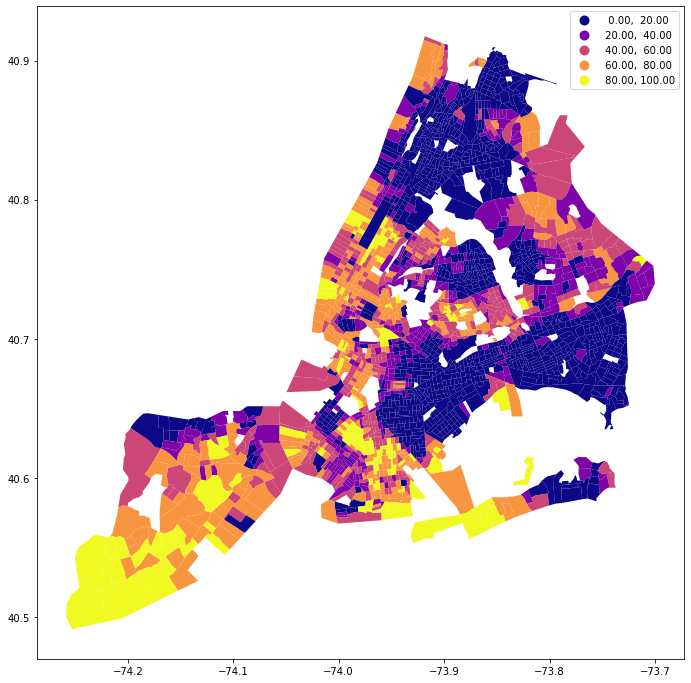

In [20]:
race_Df.plot(figsize=(12,12),
                 column='Percent White',
                  cmap='plasma',
                 legend=True, 
                 scheme='equal_interval')

## Spatial Joining Census and Arrest Data

#### Elise Chessman

In [21]:
parkarrests.to_crs('EPSG:4326', inplace=True)
race_Df.to_crs('EPSG:4326', inplace=True)

In [22]:
allgdf = gpd.sjoin(race_Df, parkarrests, how='left', predicate='intersects')

In [23]:
allgdf

,geoid,name,Total,White,Black,American Indian and Alaska Native,Asian,Pacific Islander,Other Race,Two or more races,Hispanic,geometry,Percent White,Percent Black,Percent American Indian and Alaska Native,Percent Asian,Percent Pacific Islander,Percent Other Race,Percent Two or more races,Percent Hispanic,index_right,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,old,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,retired,communityboard,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,dist_to_park,hundred_m
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,150976.0,224175403,2021-02-10T00:00:00.000,779,"PUBLIC ADMINISTRATION,UNCLASSI",126.0,MISCELLANEOUS PENAL LAW,PL 215510B,F,Q,114,0,25-44,M,BLACK,1016252,226442,40.78815742500007,-73.88443489899998,"{'type': 'Point', 'coordinates': [-73.88443489...",39,5,4,72,14781,798.0,Randall's Island Park,None,10035,66.44805203999999,"N Of FDNY Academy, E Of Central Pking Lots; In...",68,8,Randalls Island-Sunken Meadow,12,M104,False,111,M-11R,Flagship Park Zone,25,M104-ZN02,Sunken Meadow,29,M,2576.874201,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,130404.0,226619645,2021-04-07T00:00:00.000,49,U.S. CODE UNCLASSIFIED,995.0,FOR OTHER AUTHORITIES,FOA9000049,NaN,Q,114,0,18-24,M,WHITE HISPANIC,1016513,227787,40.791848137000045,-73.88348590799995,"{'type': 'Point', 'coordinates': [-73.88348590...",39,5,4,72,14781,767.0,Soundview Park,None,10473,23.31397816,East Half Of Waterfront From Rosedale Ave To L...,85,18,Soundview Park Zone 6,15,X118,False,209,X-09,Large Park Zone,43,X118-ZN06,Soundview Park Zone 6,"32, 34",X,2491.364333,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,111145.0,228382121,2021-05-19T00:00:00.000,49,U.S. CODE UNCLASSIFIED,995.0,FOR OTHER AUTHORITIES,FOA9000049,NaN,Q,114,0,18-24,M,BLACK,1016513,227787,40.791848137000045,-73.88348590799995,"{'type': 'Point', 'coordinates': [-73.88348590...",39,5,4,72,14781,767.0,Soundview Park,None,10473,23.31397816,East Half Of Waterfront From Rosedale Ave To L...,85,18,Soundview Park Zone 6,15,X118,False,209,X-09,Large Park Zone,43,X118-ZN06,Soundview Park Zone 6,"32, 34",X,2491.364333,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,71521.0,230246752,2021-06-30T00:00:00.000,792,WEAPONS POSSESSION 1 & 2,118.0,DANGEROUS WEAPONS,PL 265031B,F,Q,114,0,18-24,M,BLACK,1016513,227787,40.791848137000045,-73.88348590799995,"{'type': 'Point', 'coordinates': [-73.88348590...",39,5,4,72,14781,767.0,Soundview Park,None,10473,23.31397816,East Half Of Waterfront From Rosedale Ave To L...,85,18,Soundview Park Zone 6,15,X118,False,209,X-09,Large Park Zone,43,X118-ZN06,Soundview Park Zone 6,"32, 34",X,2491.364333,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,139979.0,224568514,2021-02-19T00:00:00.000,49,U.S. CODE UNCLASSIFIED,995.

From my previous data exploration looking at the type of arrests that happen near parks vs. the arrest dataset broadly, I found that there was generally very little difference between the arrests close to parks and the entire arrest dataset when it comes to the type of arrests that happen. One that did increase was the percentage of dangerous drug arrests (7.6% of  arrests near parks in 2021 as opposed to 6.7% for the arrests overall). So next I'll use arrests near parks as my total dataset to try to predict (?)

In [24]:
allgdf['drug_offense']=allgdf.ofns_desc=='DANGEROUS DRUGS'
allgdf

,geoid,name,Total,White,Black,American Indian and Alaska Native,Asian,Pacific Islander,Other Race,Two or more races,Hispanic,geometry,Percent White,Percent Black,Percent American Indian and Alaska Native,Percent Asian,Percent Pacific Islander,Percent Other Race,Percent Two or more races,Percent Hispanic,index_right,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,old,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,retired,communityboard,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,dist_to_park,hundred_m,drug_offense
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,150976.0,224175403,2021-02-10T00:00:00.000,779,"PUBLIC ADMINISTRATION,UNCLASSI",126.0,MISCELLANEOUS PENAL LAW,PL 215510B,F,Q,114,0,25-44,M,BLACK,1016252,226442,40.78815742500007,-73.88443489899998,"{'type': 'Point', 'coordinates': [-73.88443489...",39,5,4,72,14781,798.0,Randall's Island Park,None,10035,66.44805203999999,"N Of FDNY Academy, E Of Central Pking Lots; In...",68,8,Randalls Island-Sunken Meadow,12,M104,False,111,M-11R,Flagship Park Zone,25,M104-ZN02,Sunken Meadow,29,M,2576.874201,False,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,130404.0,226619645,2021-04-07T00:00:00.000,49,U.S. CODE UNCLASSIFIED,995.0,FOR OTHER AUTHORITIES,FOA9000049,NaN,Q,114,0,18-24,M,WHITE HISPANIC,1016513,227787,40.791848137000045,-73.88348590799995,"{'type': 'Point', 'coordinates': [-73.88348590...",39,5,4,72,14781,767.0,Soundview Park,None,10473,23.31397816,East Half Of Waterfront From Rosedale Ave To L...,85,18,Soundview Park Zone 6,15,X118,False,209,X-09,Large Park Zone,43,X118-ZN06,Soundview Park Zone 6,"32, 34",X,2491.364333,False,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,111145.0,228382121,2021-05-19T00:00:00.000,49,U.S. CODE UNCLASSIFIED,995.0,FOR OTHER AUTHORITIES,FOA9000049,NaN,Q,114,0,18-24,M,BLACK,1016513,227787,40.791848137000045,-73.88348590799995,"{'type': 'Point', 'coordinates': [-73.88348590...",39,5,4,72,14781,767.0,Soundview Park,None,10473,23.31397816,East Half Of Waterfront From Rosedale Ave To L...,85,18,Soundview Park Zone 6,15,X118,False,209,X-09,Large Park Zone,43,X118-ZN06,Soundview Park Zone 6,"32, 34",X,2491.364333,False,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,71521.0,230246752,2021-06-30T00:00:00.000,792,WEAPONS POSSESSION 1 & 2,118.0,DANGEROUS WEAPONS,PL 265031B,F,Q,114,0,18-24,M,BLACK,1016513,227787,40.791848137000045,-73.88348590799995,"{'type': 'Point', 'coordinates': [-73.88348590...",39,5,4,72,14781,767.0,Soundview Park,None,10473,23.31397816,East Half Of Waterfront From Rosedale Ave To L...,85,18,Soundview Park Zone 6,15,X118,False,209,X-09,Large Park Zone,43,X118-ZN06,Soundview Park Zone 6,"32, 34",X,2491.364333,False,False
0,14000US36005000100,"Census Tract 1, Bronx, NY",6600.0,817.0,3234.0,27.0,171.0,0.0,0.0,36.0,2315.0,"MULTIPOLYGON (((-73.89772 40.79514, -73.89611 ...",12.378788,49.00,0.409091,2.590909,0.0,0.000000,0.545455,35.075758,139979.0,224568514,2021-02-19T00:00:

Now I need to create a column that combines the drug offense and distance to park boolean columns. Used & to combine the boolean columns (more about that here: https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas)
    

In [25]:
allgdf['park_drug'] =  (allgdf.hundred_m) & (allgdf.drug_offense)
allgdf.sample(20)

,geoid,name,Total,White,Black,American Indian and Alaska Native,Asian,Pacific Islander,Other Race,Two or more races,Hispanic,geometry,Percent White,Percent Black,Percent American Indian and Alaska Native,Percent Asian,Percent Pacific Islander,Percent Other Race,Percent Two or more races,Percent Hispanic,index_right,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,old,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,retired,communityboard,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,dist_to_park,hundred_m,drug_offense,park_drug
688,14000US36047036200,"Census Tract 362, Kings, NY",3678.0,1734.0,37.0,42.0,636.0,0.0,92.0,362.0,775.0,"MULTIPOLYGON (((-73.96851 40.57642, -73.96835 ...",47.145188,1.005982,1.141925,17.292007,0.000000,2.501359,9.842306,21.071234,50521.0,232081273,2021-08-11T00:00:00.000,779,"PUBLIC ADMINISTRATION,UNCLASSI",126.0,MISCELLANEOUS PENAL LAW,PL 215510B,F,K,60,0,45-64,M,BLACK HISPANIC,993059,149630,40.57737961700008,-73.96829051999998,"{'type': 'Point', 'coordinates': [-73.96829051...",21,2,15,35,13826,716.0,Ocean Parkway Malls,None,1122411235,2.55306873,Btwn Neptune Ave And Surf Ave,46,48,Ocean Parkway (5.5 Miles)-Ocean Parkway Malls ...,8,B065,False,313,B-13,Large Park Zone,60,B065-ZN10,Ocean Parkway Malls Zone 10,23,B,10.006084,True,False,False
1738,14000US36081035100,"Census Tract 351, Queens, NY",3480.0,389.0,275.0,0.0,522.0,0.0,14.0,0.0,2280.0,"MULTIPOLYGON (((-73.87895 40.76198, -73.87797 ...",11.178161,7.902299,0.000000,15.000000,0.000000,0.402299,0.000000,65.517241,3776.0,236195443,2021-11-12T00:00:00.000,109,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,Q,115,0,25-44,M,WHITE HISPANIC,1018714,214946,40.756594678000056,-73.87560301799994,"{'type': 'Point', 'coordinates': [-73.87560301...",65,3,21,73,14783,394.0,Frank D. O'Connor Playground,None,11373,0.14828634,Broadway & 78 St,39,25,O'Connors Tail-O'Connor's Tail,6,Q098,False,404,Q-04,Sitting Area/Triangle/Mall,110,Q098-01,O’Connor’s Tail,16,Q,1651.660777,False,False,False
1503,14000US36081003301,"Census Tract 33.01, Queens, NY",2370.0,815.0,111.0,0.0,908.0,0.0,7.0,166.0,363.0,"MULTIPOLYGON (((-73.94384 40.75253, -73.94375 ...",34.388186,4.683544,0.000000,38.312236,0.000000,0.295359,7.004219,15.316456,74684.0,231333442,2021-07-25T00:00:00.000,101,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,Q,114,0,45-64,F,BLACK,1002018,213258,40.75201086000004,-73.93587196099996,"{'type': 'Point', 'coordinates': [-73.93587196...",39,3,33,72,16858,58.0,Queensbridge Park,None,11101,0.48623566,41st Rd And 12th St (East Of Vernon Blvd),37,26,"Queensbridge ""Baby"" Park",12,Q104,False,401402,Q-01,Plgd Within Park,114,Q104-02,"Queensbridge ""Baby"" Park",12,Q,844.562724,False,False,False
1896,14000US36081057700,"Census Tract 577, Queens, NY",3939.0,2096.0,30.0,14.0,53.0,0.0,0.0,0.0,1746.0,"MULTIPOLYGON (((-73.89384 40.70086, -73.89274 ...",53.211475,0.761615,0.355420,1.345519,0.000000,0.000000,0.000000,44.325971,77691.0,230210505,2021-06-29T00:00:00.000,905,"INTOXICATED DRIVING,ALCOHOL",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920U2,M,Q,104,0,25-44,M,WHITE HISPANIC,1014445,193646,40.69814701200004,-73.89110760399994,"{'type': 'Point', 'coordinates': [-73.89110760...",54,3,34,62,15310,651.0,Highland Park,None,11385,68.12980238,"Highland Blvd, Vermont Pl, Jackie Robinson Pkw...","38, 54",30,Highland Park Zone 6,7,Q020,False,405,Q-05A,Large Park Zone,104,Q020-ZN06,Highland Park Zone 6,"12, 18",Q,860.931792,False,False,False
1444,14000US36061024900,"Census Tract 249, New York, NY",957.0,198.0,50.0,0.0,50.0,0.0,0.0,55.0,604.0,"MULTIPOLYGON (((-73.93792 40.83849, -73.93778 ...

## Predicting Drug Related Arrests Around Parks

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent Black','Percent Hispanic','Percent White',]
yvar = 'park_drug'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

115519 115519
38507 38507


I'll start by estimating a random forests model, and assigning the predicted y values from the test sample to y_pred.

In [28]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))



38507 38507


### Plotting the Confusion Matrix

In [29]:
y_pred

array([False, False, False, ..., False, False, False])

In [30]:
rf.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

[[38291     0]
 [  216     0]]
Accuracy score: 0.9944
              precision    recall  f1-score   support

       False       0.99      1.00      1.00     38291
        True       0.00      0.00      0.00       216

    accuracy                           0.99     38507
   macro avg       0.50      0.50      0.50     38507
weighted avg       0.99      0.99      0.99     38507



/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/envs/uds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


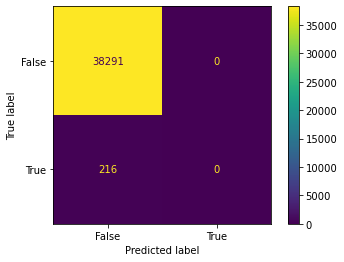

In [31]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Ok... clearly I have more work to do on this matrix since the confusion matrix has a whopping 0 in the "True and True" box. Hopefully this is something I can work through getting a better model of (and maybe mapping some of the results as well) this week! I'll plot the variables of importance as well here just to start getting an idea of where to go next.

Text(0, 0.5, 'Mean decrease in impurity')

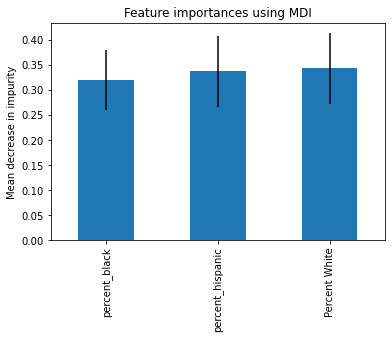

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Text(0, 0.5, 'Mean decrease in impurity')

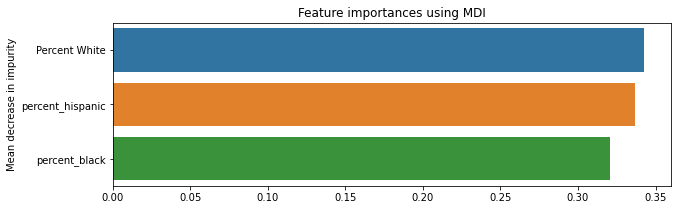

In [33]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

I'll see what happens to the confusion matrix when I try standardizing my x variables.

In [34]:
# from sklearn import preprocessing
# from sklearn.neural_network import MLPClassifier

# # your code here

# # scale the columns
# scaler = preprocessing.StandardScaler().fit(df_to_fit[xvars])
# df_scaled = pd.DataFrame(scaler.transform(df_to_fit[xvars]), 
#                          columns=xvars, index=df_to_fit.index)

# # create a DataFrame with these scaled columns joined to the columns that we didn't scale
# df_scaled = df_scaled.join(df_to_fit[yvar])

# # standardize
# X_train, X_test, y_train, y_test = train_test_split(
#       df_scaled[xvars], df_scaled[yvar], test_size = 0.25, random_state = 1)

# # estimate the neural net
# mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
# mlp.fit(X_train, y_train)
# y_pred = mlp.predict(X_test)

# # predictions
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

So scaling the dataframe did not improve its predictive power. 

What about how the race of the census tract might factor into predicting a drug related offense in general? I'll try to just look at the drug arrests factoring in race data overall to see what it might show.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent Black','Percent Hispanic','Percent White']
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

115519 115519
38507 38507


In [36]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))



38507 38507


[[35873    94]
 [ 2480    60]]
Accuracy score: 0.9332
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     35967
        True       0.39      0.02      0.04      2540

    accuracy                           0.93     38507
   macro avg       0.66      0.51      0.50     38507
weighted avg       0.90      0.93      0.90     38507



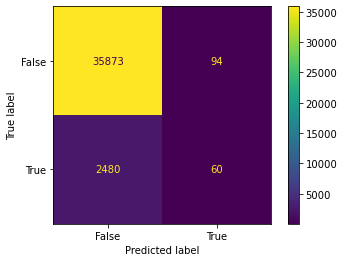

In [37]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

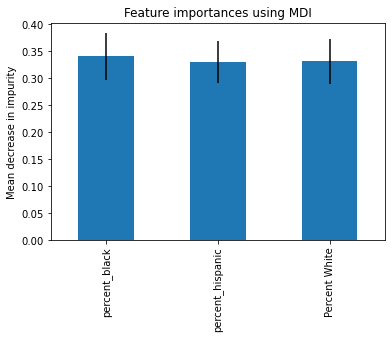

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Text(0, 0.5, 'Mean decrease in impurity')

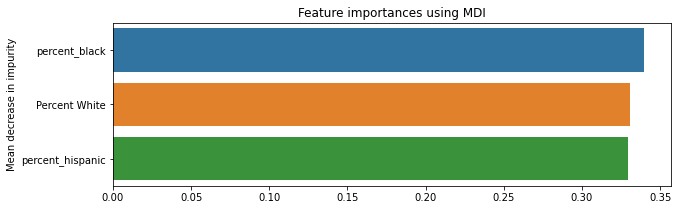

In [39]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### Shifting the prediction a bit

Do race demographics, park location, and proximity to a park factor into the prediction of a drug related offense?

In [40]:
# convert propname (the parks) to a dummy variable

dummies = pd.get_dummies(allgdf.propname, prefix='parkname_')  
print(allgdf.propname.head())
dummies.head()

0    Randall's Island Park
0           Soundview Park
0           Soundview Park
0           Soundview Park
0           Soundview Park
Name: propname, dtype: object


,parkname__Alley Pond Park,parkname__Aqueduct Walk,parkname__Archie Spigner Park,parkname__Arden Woods,parkname__Asphalt Green,parkname__Asser Levy Park,parkname__Astoria Park,parkname__Bailey Playground,parkname__Baisley Pond Park,parkname__Battery Park City,parkname__Bayswater Park,parkname__Belt Parkway/Shore Parkway,parkname__Bensonhurst Park,parkname__Betsy Head Park,parkname__Bloomingdale Park,parkname__Blue Heron Park,parkname__Bowne Park,parkname__Breukelen Ballfields,parkname__Broadway Malls,parkname__Bronx Park,parkname__Bronx River Parkway,parkname__Brookfield Park,parkname__Brooklyn Bridge Park,parkname__Brookville Park,parkname__Brower Park,parkname__CPL. Thompson Park,parkname__Calvert Vaux Park,parkname__Canarsie Park,parkname__Captain Tilly Park,parkname__Carl Schurz Park,parkname__Central Park,parkname__Claremont Park,parkname__Clove Lakes Park,parkname__Coffey Park,parkname__Commodore Barry Park,parkname__Coney Island Beach & Boardwalk,parkname__Coney Island Boat Basin,parkname__Conference House Park,parkname__Cooper Park,parkname__Crescent Beach Park,parkname__Crocheron Park,parkname__Crotona Park,parkname__Crotona Parkway Malls,parkname__Cunningham Park,parkname__Detective Keith L Williams Park,parkname__Devoe Park,parkname__Dyker Beach Park,parkname__East River Walk,parkname__East River Waterfront Esplanade,parkname__Eastern Parkway,parkname__Ewen Park,parkname__Fairview Park,parkname__Ferry Point Park,parkname__Flushing Fields,parkname__Flushing Meadows Corona Park,parkname__Forest Park,parkname__Fort Greene Park,parkname__Fort Totten Park,parkname__Fort Tryon Park,parkname__Fort Washington Park,parkname__Francis Lewis Park,parkname__Frank D. O'Connor Playground,parkname__Frank Golden Park,parkname__Frank Principe Park,parkname__Franklin D. Roosevelt Boardwalk and Beach,parkname__Franz Sigel Park,parkname__Freshkills Park,parkname__Givan Square,parkname__Goodhue Park,parkname__Grand Central Parkway,parkname__Great Kills Park,parkname__Haffen Park,parkname__Hallets Cove Playground,parkname__Harlem River Park,parkname__Harris Park,parkname__Harvey Park,parkname__Henry Hudson Park,parkname__Herbert Von King Park,parkname__Hermon A. MacNeil Park,parkname__Highbridge Park,parkname__Highland Park,parkname__Hunter's Point South Park,parkname__Idlewild Park,parkname__Inwood Hill Park,parkname__Isham Park,parkname__J. Hood Wright Park,parkname__Jackie Robinson Park,parkname__Jamaica Bay Park,parkname__John V. Lindsay East River Park,parkname__Juniper Valley Park,parkname__Kaiser Park,parkname__Kissena Corridor Park,parkname__Kissena Park,parkname__Laurelton Parkway,parkname__Leif Ericson Park,parkname__Lemon Creek Park,parkname__Lincoln Terrace / Arthur S. Somers Park,parkname__Linden Park,parkname__Lindower Park,parkname__Little Bay Park,parkname__Long Pond Park,parkname__Macombs Dam Park,parkname__Madison Square Park,parkname__Manhattan Beach Park,parkname__Marcus Garvey Park,parkname__Maria Hernandez Park,parkname__Marine Park,parkname__McCarren Park,parkname__McGuire Fields,parkname__McKinley Park,parkname__Merriam Playground,parkname__Morningside Park,parkname__Mosholu Parkway,parkname__Msgr. McGolrick Park,parkname__Mullaly Park,parkname__Ocean Breeze Park,parkname__Ocean Parkway Malls,parkname__Owl's Head Park,parkname__Park Avenue Malls,parkname__Pelham Bay Park,parkname__Pelham Parkway,parkname__Powell's Cove Park,parkname__Prospect Park,parkname__Pugsley Creek Park,parkname__Queens Farm Park,parkname__Queensbridge Park,parkname__Rainey Park,parkname__Randall's Island Park,parkname__Red Hook Recreation Area,parkname__Richman (Echo) Park,parkname__Richmond Parkway,parkname__River Avenue Parks,parkname__Riverdale Park,parkname__Riverside Park,parkname__Riverside Park South,parkname__Rochdale Park,parkname__Rockaway Beach,parkname__Rockaway Beach Boardwalk,parkname__Rockaway Beach and Boardwalk,parkname__Rockaway Community Park,parkname__Rockaway Freeway,parkname__Roy Wilkins Recreation Center,parkname__Rufu

In [41]:
allgdf = allgdf.join(dummies)
allgdf.head()

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['Percent Black','Percent Hispanic','Percent White','hundred_m', 'dist_to_park']
yvar = 'drug_offense'

df_to_fit = allgdf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )


115515 115515
38506 38506


In [45]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

print(len(X_test), len(y_pred))

38506 38506


[[35061   845]
 [ 1808   792]]
Accuracy score: 0.9311
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     35906
        True       0.48      0.30      0.37      2600

    accuracy                           0.93     38506
   macro avg       0.72      0.64      0.67     38506
weighted avg       0.92      0.93      0.92     38506



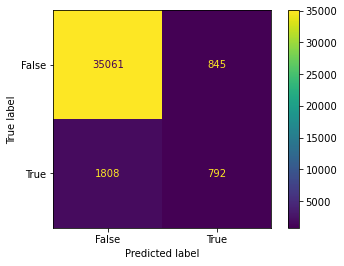

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Text(0, 0.5, 'Mean decrease in impurity')

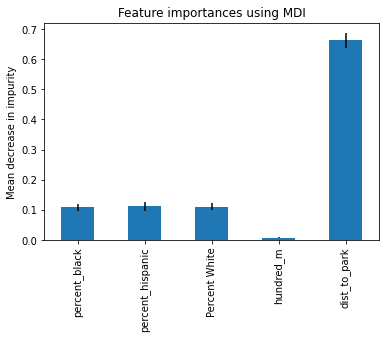

In [48]:
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Text(0, 0.5, 'Mean decrease in impurity')

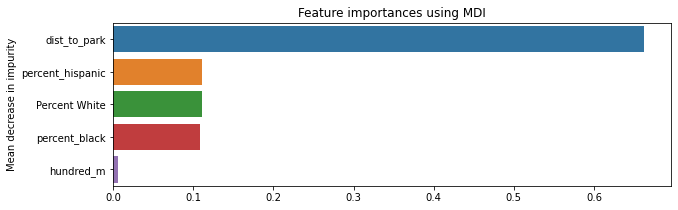

In [49]:
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")